In [1]:
from time import perf_counter
import numpy as np
from scipy.sparse import csr_matrix
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Example:  Thermoelastic rod 

Run notebook straight down to generate some data from the paper.

In [2]:
# Parameters of the simulation
N = 250
D = 2*N+1
gamma = 0.1
m = 1

# Generate L,M matrices
zz = np.zeros((N,N))
ii = np.eye(N)
ll = np.block([[zz,ii],[-ii,zz]])
Ld = np.zeros((D,D))
Ld[:-1,:-1] = ll
L = csr_matrix(Ld)

def M(t,y):
    p = y[N:-1]
    mtx = np.zeros((D,D))
    mtx[N:-1,N:-1] = np.eye(N)
    mtx[N:-1,-1]= -p/m
    mtx[-1,N:-1]= -p/m
    mtx[-1,-1] = np.dot(p/m,p/m)
    return csr_matrix(gamma * mtx)

def EE(y):
    return 1/(2*m)*np.sum(y[N:-1]*y[N:-1], 0) \
           + np.sum(np.cos(y[:N]),0) + y[-1]

# Generate gradient functions
def gradE(t,y):
    out = np.zeros_like(y)
    out[:N] = -np.sin(y[:N]) #-np.sin(np.dot(y[:N],y[:N]))*y[:N]
    out[N:-1] = y[N:-1]/m
    out[-1] = 1
    return out

gradS = np.zeros(D)
gradS[-1] = 1

# Define vectors w^\alpha = v^\alpha / E^{k_0}
# We choose k_0 = 2N+1 since E^{2N+1}=1 for all x
def Mvecs(t,y):
    mtx = np.zeros((D,N))
    mtx[N:-1] = np.eye(N)
    mtx[-1] = -y[N:-1]/m
    vecs = np.sqrt(gamma)*mtx.T
    return csr_matrix(vecs)
    
# Define full order system in matrix and vector forms
def FOrhs(t,y):
    q = y[:N]
    p = y[N:-1]
    S = y[-1]
    out = np.zeros(D)
    out[:N] = p/m
    out[N:-1] = np.sin(q) - gamma*p/m
    out[-1] = gamma*np.dot(p,p)/(m*m)  #-10/T2*(1/T1 - 1/T2)
    return out

def FOrhsM(t,y): return L @ gradE(t,y) + M(t,y) @ gradS

def FOrhsM2(t,y):
    vec = Mvecs(t,y)
    Mterm = np.sum((vec @ gradS)*vec.todense(),0)
    return L @ gradE(t,y) + Mterm

## Generate POD decomposition

Also plots eigenvalues

/Users/agrubertx/miniconda3/envs/new38/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


energy distribution is [46.9837835   5.16997154  3.47140644  2.49264551  1.82156138  1.68169497
  1.61995914  1.49693267  1.42269533  1.27929004  1.24411808  1.1953004
  1.12017431  1.025175    1.01768261  0.95324237  0.92275821  0.86914365
  0.85444584  0.82122932  0.79518181  0.76549906  0.73772704  0.72523472
  0.6866397   0.65743362  0.63138432  0.5905144   0.57982639  0.54191313
  0.52465963  0.49120077  0.47522478  0.46358833  0.45059317  0.43615052
  0.41385985  0.38128026  0.36133832  0.34429826  0.32313542  0.31279554
  0.30119489  0.28456752  0.2810799   0.27696308  0.26517189  0.2472043
  0.24430161  0.23524826]


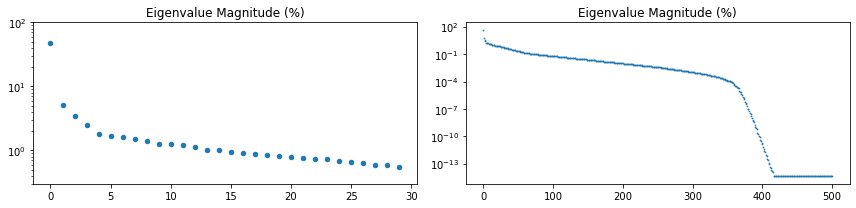

In [3]:
# Random seed for reproducibility
np.random.seed(2)

T = 8  #training time right endpoint

# Generate initial conditions
l = np.concatenate((-0.2*np.ones(N),-1*np.ones(N),[1]))
u = np.concatenate((5.2*np.ones(N),1*np.ones(N),[3]))
x = np.random.rand(25,D)
ics = x*l + (1-x)*u

# Semidiscretize the "rod"
space = np.linspace(0,1,N)
for ic in ics:
    ic[0:N] = np.exp(ic[0]*space)
    ic[N:2*N] = 1/(1 + ic[N]*space**2)

# Generate snapshots
tt = np.arange(0,T,0.02)  #training t-range
snapsL = []
for ic in ics:
    ss = solve_ivp(FOrhs, (0,T), ic, method='LSODA',
                   dense_output=True, atol=1e-14, rtol=1e-14)
    snapsL.append(ss.sol(tt) - ic.reshape(-1,1))
    snapsL.append(gradE(0,ss.sol(tt)))   
snapsL.append(gradS)
snaps = snapsL[0]
for i in range(len(snapsL)-1):
    snaps = np.concatenate((snaps,snapsL[i]), axis=1)
 
# Computing reduced basis
Ubig, S, _ = np.linalg.svd(snaps, full_matrices=False)
print(f'energy distribution is {S[:50] / np.sum(S) * 100}')

fig, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].scatter(range(30),S[:30] / np.sum(S) * 100, s=20)
ax[0].set_yscale("log")
ax[0].set_ylim([3*10**-1,10**2])
ax[1].scatter(range(501),S[:501] / np.sum(S) * 100, s=0.5)
ax[1].set_yscale("log")
ax[0].set_title('Eigenvalue Magnitude (%)')
ax[1].set_title('Eigenvalue Magnitude (%)')
plt.tight_layout()
# plt.savefig('nbody_evals.png', format='png', tight_layout=True)

### RHS functions without manual optimization

In [4]:
n = 6
U = Ubig[:,:n]

# Precomputing xi part
gradSr = U[-1]  #U.T @ gradS
Lr = U.T @ L @ U
Lhgs = Lr @ U[-1]
# Assuming gradS[-1] = 1...
Lmat = np.tensordot(U[-1],Lhgs,0) - np.tensordot(Lhgs,U[-1],0) + np.dot(U[-1],gradSr)*Lr

# Computing reduced gradients
def gradEr(t,y):
    return U.T @ gradE(t,y)

# Compute ROM rhs
def ROrhsMnoOpt(t,y,ic):
    gradEred = gradEr(t,ic+U@y)
    wHat = Mvecs(t,ic+U@y) @ U
    vec = np.tensordot(wHat @ gradEred, U[-1], axes=0) \
            - np.dot(U[-1], gradEred) * wHat
    Mterm = np.sum((vec @ gradSr).reshape(-1,1) * vec, 0)
    return Lmat @ gradEred + Mterm

# Others for comparison
LL = U.T @ L 
def ROrhsNoSPnoOpt(t,y,ic): 
    return LL @ gradE(t,ic+U@y) + U.T @ M(t,ic+U@y) @ gradS

Pt = U @ U.T
Lpart = U.T @ L @ Pt
def ROrhsOldnoOpt(t,y,ic): 
    return Lpart @ gradE(t,ic+U@y) + U.T @ M(t,ic+U@y) @ Pt[:,-1]  #Pt @ gradS

### RHS functions with manual optimization

n controls the reduced dimension 

In [5]:
n = 5
U = Ubig[:,:n]

# Precomputing xi part
gradSr = U[-1]  #U.T @ gradS
Lr = U.T @ L @ U
Lhgs = Lr @ U[-1]

# Assuming gradS[-1] = 1...
Lmat = np.tensordot(U[-1],Lhgs,0) - np.tensordot(Lhgs,U[-1],0) + np.dot(U[-1],gradSr)*Lr

# Manually optimized U.T@gradE
def gradEr(t,y):
    return -np.sum(np.sin(y[:N]).reshape(-1,1)*U[:N],0) \
            + 1/m*np.sum(y[N:-1].reshape(-1,1)*U[N:-1],0) + U[-1]

#### Precomputing M part

# First compute v0
vMat0 = np.zeros((D,N))
vMat0[N:-1] = np.eye(N)
vMat0[-1] = -ic[N:-1]/m
vMat0 = np.sqrt(gamma)*vMat0
vMatRed0 = U.T @ vMat0

# vTilde = v0 + vFunc
def vFunc(t,y): 
    mat = np.zeros((D,N))
    mat[-1] = -np.sqrt(gamma)/m*(U[N:-1]@y)
    return mat

# U.T @ ((U @ xHat)[N:-1])
def vFuncRed(t,y): 
    redmat = np.tensordot(U[-1], U[N:-1] @ y, axes=0)
    return -np.sqrt(gamma)/m*redmat

##### Compute FOM and ROM rhs

def vFuncFull(t,y): 
    mat = np.zeros((D,N))
    mat[-1] = -np.sqrt(gamma)/m*(y[N:-1]-ic[N:-1])
    return mat

def FOrhsM(t,y):
    vec = (vMat0 + vFuncFull(t,y)).T
    Mterm = np.sum(vec[:,-1].reshape(-1,1)*vec,0)
    return L @ gradE(t,y) + Mterm

def ROrhsM(t,y,ic):
    gradEred = gradEr(t,ic+U@y)
    wHat = (vMatRed0 + vFuncRed(t,y)).T
    vec = np.tensordot(wHat @ gradEred, U[-1], axes=0) \
          - np.dot(U[-1], gradEred) * wHat
    Mterm = np.sum((vec @ gradSr).reshape(-1,1) * vec, 0)
    return Lmat @ gradEred + Mterm

# Other ROMs for comparison

LL = U.T @ L 
Pt = U @ U.T
Lpart = U.T @ L @ Pt

def ROrhsNoSP(t,y,ic):
    factor = (vMat0 + vFunc(t,y))[-1]   #m^\alpha \cdot \nabla S
    wHat = (vMatRed0 + vFuncRed(t,y)).T
    Mterm = np.sum(factor.reshape(-1,1)*wHat,0)
    return LL @ gradE(t,ic+U@y) + Mterm

def ROrhsOld(t,y,ic):
    Lterm = Lpart @ gradE(t,ic+U@y)
    wHat = (vMatRed0 + vFuncRed(t,y)).T
    Mterm = np.sum((wHat@gradSr).reshape(-1,1)*wHat, 0)
    return Lterm + Mterm

## Solving the ROM

T controls the final integration time.  Also prints errors and plots solutions (this part is hard coded and ugly).

time of FOM is 0.59523875
time of new ROM is 0.7229459589999996
time of old ROM is 0.19818191699999943
time of no-SP ROM is 0.3890951669999998
relative errors are 0.09197254864355615 (new), 0.18195415349345087 (old), 0.1520041744555703 (no)
max errors are 42.973294833715784 (new), 154.03713708066056 (old), 122.61328429784368 (no)
no S max errors are 2.953981779577137 (new), 3.1974766630852898 (old), 6.99673290634673 (no)
n is 20
time of FOM is 0.5998566250000001
time of new ROM is 0.7474114580000002
time of old ROM is 0.252960667
time of no-SP ROM is 0.43671349999999975
relative errors are 0.04455964235825637 (new), 0.0907898940383817 (old), 1.0726867754114466 (no)
max errors are 21.094470338794224 (new), 68.67862998131676 (old), 1498.2337337985618 (no)
no S max errors are 1.6577642834651023 (new), 2.052139000791634 (old), 61.34887832084863 (no)
n is 40
time of FOM is 0.6125339590000003
time of new ROM is 0.6981023750000013
time of old ROM is 0.26302345899999935
time of no-SP ROM is 0.

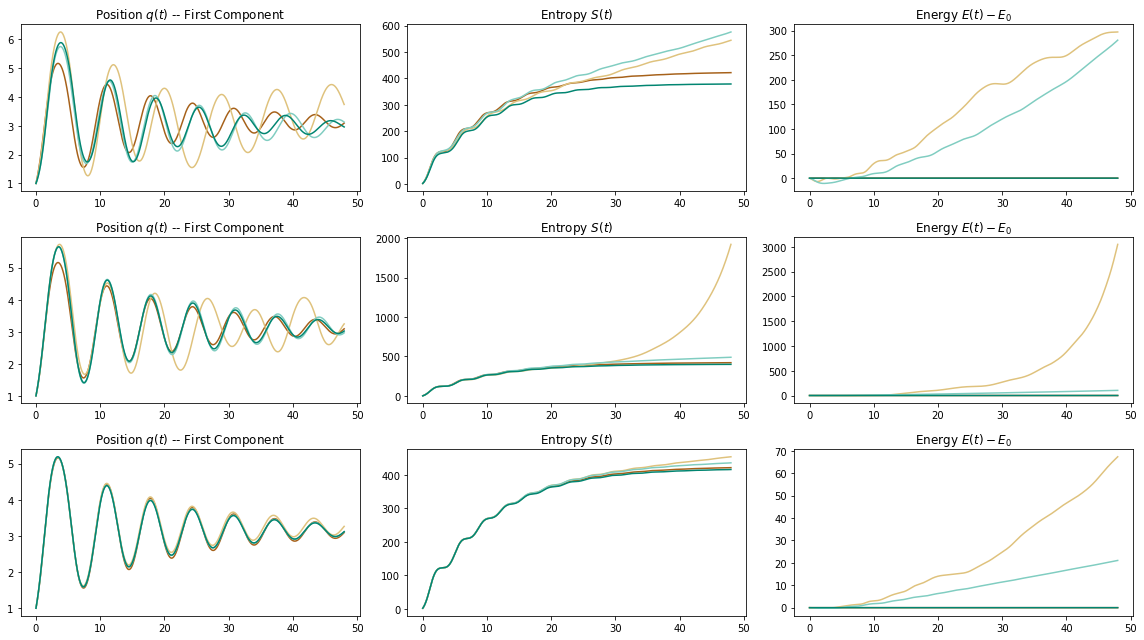

In [6]:
np.random.seed(3)

T=48
tt = np.arange(0,T,0.02)

ic = np.zeros(501)
ic[:N] = np.exp(0.65*space)
ic[N:-1] = 1/(1-0.1*space**2)
ic[-1] = 1.9


################ n=10 ##################

n = 10
U = Ubig[:,:n]

# Precomputing xi part
gradSr = U[-1]  #U.T @ gradS
Lr = U.T @ L @ U
Lhgs = Lr @ U[-1]
# Assuming gradS[-1] = 1...
Lmat = np.tensordot(U[-1],Lhgs,0) - np.tensordot(Lhgs,U[-1],0) + np.dot(U[-1],gradSr)*Lr

#### Precomputing M part
vMat0 = np.zeros((D,N))
vMat0[N:-1] = np.eye(N)
vMat0[-1] = -ic[N:-1]/m
vMat0 = np.sqrt(gamma)*vMat0
vMatRed0 = U.T @ vMat0

# Others for comparison
LL = U.T @ L 
Pt = U @ U.T
Lpart = U.T @ L @ Pt

start = perf_counter()
sol1 = solve_ivp(FOrhsM, (0,T), ic, method='LSODA',
                 dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of FOM is {end-start}')

start = perf_counter()
solNew = solve_ivp(lambda t,y: ROrhsM(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of new ROM is {end-start}')

start = perf_counter()
solOld = solve_ivp(lambda t,y: ROrhsOld(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of old ROM is {end-start}')

start = perf_counter()
solNo = solve_ivp(lambda t,y: ROrhsNoSP(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of no-SP ROM is {end-start}')

ex2 = sol1.sol(tt)
recNew2 = ic.reshape(-1,1) + U @ solNew.sol(tt)
recOld2 = ic.reshape(-1,1) + U @ solOld.sol(tt)
recNo2 = ic.reshape(-1,1) + U @ solNo.sol(tt)

relEnew = np.linalg.norm(recNew2-ex2)/np.linalg.norm(ex2)
relEold = np.linalg.norm(recOld2-ex2)/np.linalg.norm(ex2) 
relEno = np.linalg.norm(recNo2-ex2)/np.linalg.norm(ex2) 

maxEnew = np.amax(np.sqrt((recNew2-ex2)*(recNew2-ex2)))
maxEold = np.amax(np.sqrt((recOld2-ex2)*(recOld2-ex2)))
maxEno = np.amax(np.sqrt((recNo2-ex2)*(recNo2-ex2)))

mxEnew = np.amax(np.sqrt((recNew2[:-2]-ex2[:-2])*(recNew2[:-2]-ex2[:-2])))
mxEold = np.amax(np.sqrt((recOld2[:-2]-ex2[:-2])*(recOld2[:-2]-ex2[:-2])))
mxEno = np.amax(np.sqrt((recNo2[:-2]-ex2[:-2])*(recNo2[:-2]-ex2[:-2])))

print(f'relative errors are {relEnew} (new), {relEold} (old), {relEno} (no)')
print(f'max errors are {maxEnew} (new), {maxEold} (old), {maxEno} (no)')
print(f'no S max errors are {mxEnew} (new), {mxEold} (old), {mxEno} (no)')

################ n=20 ##################

# Computing reduced basis
n = 20
U = Ubig[:,:n]

print(f'n is {n}')

# Computing LtensR and reduced gradS
gradSr = U[-1]
Lr = U.T @ L @ U
Lhgs = Lr @ U[-1]
# Assuming gradS[-1] = 1...
Lmat = np.tensordot(U[-1],Lhgs,0) - np.tensordot(Lhgs,U[-1],0) + np.dot(U[-1],gradSr)*Lr

# First compute v0
vMat0 = np.zeros((D,N))
vMat0[N:-1] = np.eye(N)
vMat0[-1] = -ic[N:-1]/m
vMat0 = np.sqrt(gamma)*vMat0
vMatRed0 = U.T @ vMat0

LL = U.T @ L 
Pt = U @ U.T
Lpart = U.T @ L @ Pt

start = perf_counter()
sol1 = solve_ivp(FOrhsM, (0,T), ic, method='LSODA',
                 dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of FOM is {end-start}')

start = perf_counter()
solNew = solve_ivp(lambda t,y: ROrhsM(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of new ROM is {end-start}')

start = perf_counter()
solOld = solve_ivp(lambda t,y: ROrhsOld(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of old ROM is {end-start}')

start = perf_counter()
solNo = solve_ivp(lambda t,y: ROrhsNoSP(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of no-SP ROM is {end-start}')

ex3 = sol1.sol(tt)
recNew3 = ic.reshape(-1,1) + U @ solNew.sol(tt)
recOld3 = ic.reshape(-1,1) + U @ solOld.sol(tt)
recNo3 = ic.reshape(-1,1) + U @ solNo.sol(tt)

relEnew = np.linalg.norm(recNew3-ex3)/np.linalg.norm(ex3)
relEold = np.linalg.norm(recOld3-ex3)/np.linalg.norm(ex3) 
relEno = np.linalg.norm(recNo3-ex3)/np.linalg.norm(ex3) 

maxEnew = np.amax(np.sqrt((recNew3-ex3)*(recNew3-ex3)))
maxEold = np.amax(np.sqrt((recOld3-ex3)*(recOld3-ex3)))
maxEno = np.amax(np.sqrt((recNo3-ex3)*(recNo3-ex3)))

mxEnew = np.amax(np.sqrt((recNew3[:-2]-ex3[:-2])*(recNew3[:-2]-ex3[:-2])))
mxEold = np.amax(np.sqrt((recOld3[:-2]-ex3[:-2])*(recOld3[:-2]-ex3[:-2])))
mxEno = np.amax(np.sqrt((recNo3[:-2]-ex3[:-2])*(recNo3[:-2]-ex3[:-2])))

print(f'relative errors are {relEnew} (new), {relEold} (old), {relEno} (no)')
print(f'max errors are {maxEnew} (new), {maxEold} (old), {maxEno} (no)')
print(f'no S max errors are {mxEnew} (new), {mxEold} (old), {mxEno} (no)')

################ n=40 ##################

# Computing reduced basis
n = 40
U = Ubig[:,:n]

print(f'n is {n}')

# Computing LtensR and reduced gradS
gradSr = U[-1]
Lr = U.T @ L @ U
Lhgs = Lr @ U[-1]
# Assuming gradS[-1] = 1...
Lmat = np.tensordot(U[-1],Lhgs,0) - np.tensordot(Lhgs,U[-1],0) + np.dot(U[-1],gradSr)*Lr

# First compute v0
vMat0 = np.zeros((D,N))
vMat0[N:-1] = np.eye(N)
vMat0[-1] = -ic[N:-1]/m
vMat0 = np.sqrt(gamma)*vMat0
vMatRed0 = U.T @ vMat0

LL = U.T @ L 
Pt = U @ U.T
Lpart = U.T @ L @ Pt

start = perf_counter()
sol1 = solve_ivp(FOrhsM, (0,T), ic, method='LSODA',
                 dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of FOM is {end-start}')

start = perf_counter()
solNew = solve_ivp(lambda t,y: ROrhsM(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of new ROM is {end-start}')

start = perf_counter()
solOld = solve_ivp(lambda t,y: ROrhsOld(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of old ROM is {end-start}')

start = perf_counter()
solNo = solve_ivp(lambda t,y: ROrhsNoSP(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of no-SP ROM is {end-start}')

ex4 = sol1.sol(tt)
recNew4 = ic.reshape(-1,1) + U @ solNew.sol(tt)
recOld4 = ic.reshape(-1,1) + U @ solOld.sol(tt)
recNo4 = ic.reshape(-1,1) + U @ solNo.sol(tt)

relEnew = np.linalg.norm(recNew4-ex4)/np.linalg.norm(ex4)
relEold = np.linalg.norm(recOld4-ex4)/np.linalg.norm(ex4) 
relEno = np.linalg.norm(recNo4-ex4)/np.linalg.norm(ex4) 

maxEnew = np.amax(np.sqrt((recNew4-ex4)*(recNew4-ex4)))
maxEold = np.amax(np.sqrt((recOld4-ex4)*(recOld4-ex4)))
maxEno = np.amax(np.sqrt((recNo4-ex4)*(recNo4-ex4)))

mxEnew = np.amax(np.sqrt((recNew4[:-2]-ex4[:-2])*(recNew4[:-2]-ex4[:-2])))
mxEold = np.amax(np.sqrt((recOld4[:-2]-ex4[:-2])*(recOld4[:-2]-ex4[:-2])))
mxEno = np.amax(np.sqrt((recNo4[:-2]-ex4[:-2])*(recNo4[:-2]-ex4[:-2])))

print(f'relative errors are {relEnew} (new), {relEold} (old), {relEno} (no)')
print(f'max errors are {maxEnew} (new), {maxEold} (old), {maxEno} (no)')
print(f'no S max errors are {mxEnew} (new), {mxEold} (old), {mxEno} (no)')

############### Plotting ################

ugh2 = EE(ex2[:,0])
ugh3 = EE(ex3[:,0])
ugh4 = EE(ex4[:,0])
Eex2 = EE(ex2) - ugh2
Eex3 = EE(ex3) - ugh3
Eex4 = EE(ex4) - ugh4
Enew2 = EE(recNew2) - ugh2
Enew3 = EE(recNew3) - ugh3
Enew4 = EE(recNew4) - ugh4
Eold2 = EE(recOld2) - ugh2
Eold3 = EE(recOld3) - ugh3
Eold4 = EE(recOld4) - ugh4
Eno2 = EE(recNo2) - ugh2
Eno3 = EE(recNo3) - ugh3
Eno4 = EE(recNo4) - ugh4

EList = [Eex2, Eex3, Eex4, Eno2, Eno3, Eno4, 
         Eold2, Eold3, Eold4, Enew2, Enew3, Enew4]
solList = [ex2, ex3, ex4, recNo2, recNo3, recNo4, 
           recOld2, recOld3, recOld4, recNew2, recNew3, recNew4]

cList = ['#a6611a', '#dfc27d', '#80cdc1', '#018571']
# cList = ['#ffff99', '#fdc086', '#beaed4', '#7fc97f']
# cList = ['#e78ac3', '#8da0cb', '#fc8d62', '#66c2a5']
            
fig, ax = plt.subplots(3,3, figsize=(16,9))
for i in range(4):
    ax[0,2].plot(tt, EList[3*i], color=cList[i])
    ax[1,2].plot(tt, EList[3*i+1], color=cList[i])
    ax[2,2].plot(tt, EList[3*i+2], color=cList[i])
    ax[0,0].plot(tt, solList[3*i][0], color=cList[i])
    ax[1,0].plot(tt, solList[3*i+1][0], color=cList[i])
    ax[2,0].plot(tt, solList[3*i+2][0], color=cList[i])
    ax[0,1].plot(tt, solList[3*i][-1], color=cList[i])
    ax[1,1].plot(tt, solList[3*i+1][-1], color=cList[i])
    ax[2,1].plot(tt, solList[3*i+2][-1], color=cList[i])   
for i in range(3):
    ax[i,0].title.set_text('Position $q(t)$ -- First Component')
    ax[i,1].title.set_text('Entropy $S(t)$')
    ax[i,2].title.set_text('Energy $E(t)-E_0$')
plt.tight_layout()
# plt.savefig('nbodies_wacky_16.png', format='png', tight_layout=True)

print(f'Change in energy n=2 is {Eex2[-1]} (exact), {Enew2[-1]} (new), {Eold2[-1]} (old), {Eno2[-1]} (no).')
print(f'Change in energy n=3 is {Eex3[-1]} (exact), {Enew3[-1]} (new), {Eold3[-1]} (old), {Eno3[-1]} (no).')
print(f'Change in energy n=4 is {Eex4[-1]} (exact), {Enew4[-1]} (new), {Eold4[-1]} (old), {Eno4[-1]} (no).')